# Setup

Load required packages

In [1]:
import pandas as pd
import io
import requests
import numpy as np
import random
import libpysal
import pysal

C:\ProgramData\Anaconda3\lib\site-packages\pysal\model\spvcm\abstracts.py:10: UserWarning: The `dill` module is required to use the sqlite backend fully.
  from .sqlite import head_to_sql, start_sql


Load data

In [2]:
#Read from URL (Doesnt work for private repos)
#url="https://github.com/konstantinklemmer/spacegan/raw/master/data/synth_data.csv"
#s=requests.get(url).content
#data=pd.read_csv(io.StringIO(s.decode('utf-8')))

#Read from local file
data=pd.read_csv("C:/Users/Konstantin Klemmer/Documents/GitHub/spacegan/data/synth_data.csv")

Show first 5 rows

In [3]:
data.head(5)

,id,longitude,latitude,y,z
0,1,1.75,1.75,0.980099,1.370958
1,2,5.25,1.75,11.714839,-0.564698
2,3,8.75,1.75,49.355200,0.363128
3,4,12.25,1.75,110.841455,0.632863
4,5,15.75,1.75,196.393346,0.404268


In [4]:
data.shape

(841, 5)

## Analysis of spatial autocorrelation

Create distance matrix

In [5]:
dist = pysal.lib.cg.distance_matrix(np.array(data[["longitude","latitude"]]))

Get the `k` smallest distances (of the whole matrix, since the points are equally distributed)

In [6]:
k=10
u_dist = np.unique(dist)
k_min_dist = np.sort(u_dist.flatten())[:k]

In [7]:
k_min_dist

array([ 0.        ,  3.5       ,  4.94974747,  7.        ,  7.82623792,
        9.89949494, 10.5       , 11.06797181, 12.61942946, 14.        ])

Create spatial points object ([KDTree](https://pysal.readthedocs.io/en/dev/library/cg/kdtree.html))). 

In [8]:
import pysal.lib
kd = pysal.lib.cg.kdtree.KDTree(np.array(data[["longitude","latitude"]]))

Compute spatial neighbourhoods weight matrix by distance threshold ("radius")

In [9]:
#wnn = pysal.lib.weights.KNN(kd, 8, ids=data["id"]) #KNN based weights
#wdist= pysal.lib.weights.distance.DistanceBand(kd, threshold=k_min_dist[1],binary=False,p=2) #Rook
wdist= pysal.lib.weights.distance.DistanceBand(kd, threshold=k_min_dist[2],binary=True,p=2) #Queen
#wdist= pysal.lib.weights.distance.DistanceBand(kd, threshold=k_min_dist[4],binary=True,p=2) #Queen 2nd degree

In [10]:
wdist.transform = "r"

Compute Global Autocorrelation (Moran's I)

In [11]:
import esda
np.random.seed(12345)
mi = esda.moran.Moran(data["y"], wdist)

Is it significant? Plot p-value

In [12]:
mi.p_norm

0.0

Plot the t-test!

Text(0.5, 0, "Moran's I")

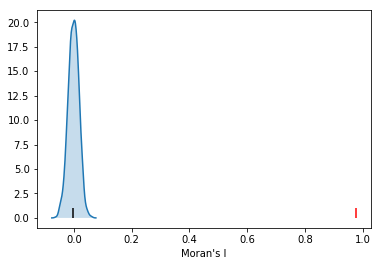

In [13]:
import matplotlib.pyplot as plt
import seaborn as sbn
sbn.kdeplot(mi.sim, shade=True)
plt.vlines(mi.I, 0, 1, color='r')
plt.vlines(mi.EI, 0,1)
plt.xlabel("Moran's I")

Compute local Moran's I

In [14]:
local_mi = esda.moran.Moran_Local(data["y"], wdist, permutations=999)
local_mi_v = local_mi.Is  
local_mi_p = local_mi.p_sim

Plot local Moran's I and p-values

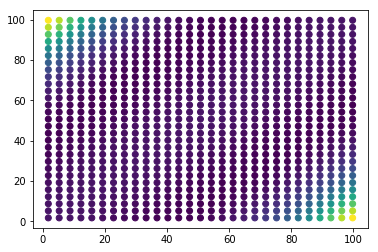

In [15]:
data["local_mi"] = local_mi_v
data["local_mi_p"] = local_mi_p

plt.scatter(data["longitude"],data["latitude"],c=data["local_mi"])

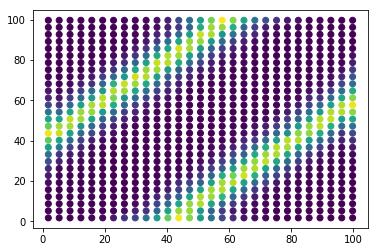

In [16]:
plt.scatter(data["longitude"],data["latitude"],c=data["local_mi_p"])